In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
init_df = pd.read_csv('../../datasets/tokenized/blog_authorship_tokenized.csv', usecols=['text', 'tokenized', 'n_words', 'gender'])
init_df.sample(15)

,text,gender,n_words,tokenized
319641,I feel so sorry that I won't be able to make t...,male,64,i feel so sorry that i wo n't be able to make ...
319734,Preface: I know GM is a horse that died a long...,male,540,preface : i know gm is a horse that died a lon...
247084,ok so i went to the gym yesterday. for an aero...,female,268,ok so i went to the gym yesterday . for an aer...
169209,"Although I have nothing to say worth reading, ...",female,710,"although i have nothing to say worth reading ,..."
201818,To dieters. . . Why exercise when you can just...,female,14,to dieters . . . why exercise when you can jus...
458765,haix..2day when to sun tec to watch movie..wat...,male,178,haix .. 2day when to sun tec to watch movie .....
391977,Work has been so busy lately. It's spooky that...,female,314,work has been so busy lately . it 's spooky th...
12865,Crimson Skies goes gold - Crimson Skies: High...,male,19,crimson skies goes gold - crimson skies : hi...
283377,A day at work makes me realize how easy a life...,male,143,a day at work makes me realize how easy a life...
40500,"As the title says, its according to FHM reader...",male,35,"as the title says , its according to fhm reade..."


In [3]:
init_df.isnull().sum()

text         0
gender       0
n_words      0
tokenized    0
dtype: int64

In [4]:
# Stratify the sample by age group
df = init_df.groupby('gender', group_keys=False).apply(lambda x: x.sample(frac=.035))
df.shape

(22245, 4)

In [5]:
df['gender'].value_counts()

male      11282
female    10963
Name: gender, dtype: int64

In [6]:
enc = LabelEncoder()
enc.fit(df['gender'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
df['gender'] = enc.transform(df['gender'])
encoded_labels

{'female': 0, 'male': 1}

## On initial data

In [7]:
X = df[['text']]
y = df['gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=123, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17796, 1), (4449, 1), (17796,), (4449,))

In [8]:
ch_2grams_cv = CountVectorizer(analyzer='char', ngram_range=(2, 2), max_features=1000, stop_words=None)
ch_3grams_cv = CountVectorizer(analyzer='char', ngram_range=(3, 3), max_features=1000, stop_words=None)
wd_2grams_cv = CountVectorizer(analyzer='word', ngram_range=(2, 2), max_features=1000, stop_words=None)
wd_3grams_cv = CountVectorizer(analyzer='word', ngram_range=(3, 3), max_features=1000, stop_words=None)

ct = ColumnTransformer([
    ('vect_ch_2', ch_2grams_cv, 'text'),
    ('vect_ch_3', ch_3grams_cv, 'text'),
    ('vect_wd_2', wd_2grams_cv, 'text'),
    ('vect_wd_3', wd_3grams_cv, 'text'),
], remainder='passthrough', n_jobs=-1)

rf = RandomForestClassifier()

pipe = make_pipeline(ct, rf)

In [13]:
param_grid = {
    'randomforestclassifier__n_estimators': [100, 250, 500, 750, 1000],
    'randomforestclassifier__max_depth': [None, 5, 10, 15, 20],
    'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss']
}

In [14]:
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5, error_score='raise')

gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
{'randomforestclassifier__criterion': 'log_loss', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 1000}


In [15]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.60      0.61      2193
           1       0.63      0.66      0.64      2256

    accuracy                           0.63      4449
   macro avg       0.63      0.63      0.63      4449
weighted avg       0.63      0.63      0.63      4449



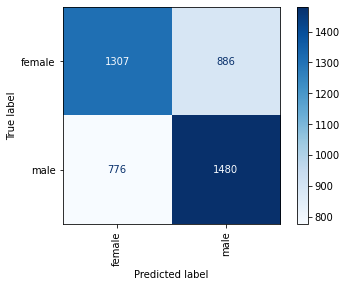

In [16]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues')
disp.ax_.tick_params(axis='x', rotation=90);

## On tokenized data

In [17]:
X = df[['tokenized']]
y = df['gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=123, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17796, 1), (4449, 1), (17796,), (4449,))

In [20]:
ch_2grams_cv = CountVectorizer(analyzer='char', ngram_range=(2, 2), max_features=1000, stop_words=None)
ch_3grams_cv = CountVectorizer(analyzer='char', ngram_range=(3, 3), max_features=1000, stop_words=None)
wd_2grams_cv = CountVectorizer(analyzer='word', ngram_range=(2, 2), max_features=1000, stop_words=None)
wd_3grams_cv = CountVectorizer(analyzer='word', ngram_range=(3, 3), max_features=1000, stop_words=None)

ct = ColumnTransformer([
    ('vect_ch_2', ch_2grams_cv, 'tokenized'),
    ('vect_ch_3', ch_3grams_cv, 'tokenized'),
    ('vect_wd_2', wd_2grams_cv, 'tokenized'),
    ('vect_wd_3', wd_3grams_cv, 'tokenized'),
], remainder='passthrough', n_jobs=-1)

rf = RandomForestClassifier()

pipe = make_pipeline(ct, rf)

In [21]:
gs_ = GridSearchCV(pipe, gs.best_params, cv=10, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5, error_score='raise')

gs_.fit(X_train, y_train)
print(gs.best_params_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params'

In [ ]:
y_pred = gs_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.62      0.62      3132
           1       0.63      0.62      0.62      3224

    accuracy                           0.62      6356
   macro avg       0.62      0.62      0.62      6356
weighted avg       0.62      0.62      0.62      6356



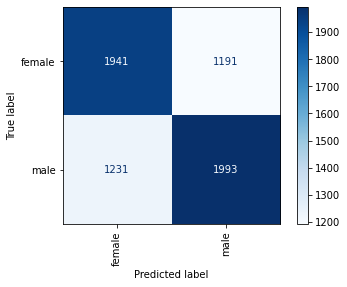

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues')
disp.ax_.tick_params(axis='x', rotation=90);